## Final Project Submission¶

Student name: Eduardo Osorio
Student pace: part time 
Scheduled project review date/time:
Instructor name: Yish Lim
Blog post URL:

In [1]:
import pandas as pd
import numpy as np


kcc = pd.read_csv('D:\Flation\mod_2\Project2\Mod_2_Project/Mod_2 _Project/data_files/kc_cleaned.csv')

continuous = ['price', 'sqft_living', 'sqft_lot']
categoricals = ['bedrooms', 'floors', 'condition', 'waterfront', 'grade', 'zipcode', 'sale_month']

kcc_cont = kcc[continuous]

# log features
log_names = [f'{column}_log' for column in kcc_cont.columns]

kcc_log = np.log(kcc_cont)
kcc_log.columns = log_names

# normalize (subract mean and divide by std)

def normalize(feature):
    return (feature - feature.mean()) / feature.std()

kcc_log_norm = kcc_log.apply(normalize)

# one hot encode categoricals
kcc_ohe = pd.get_dummies(kcc[categoricals], columns=['bedrooms', 'floors','condition', 'waterfront', 'zipcode', 'grade', 'sale_month'], drop_first=True)

preprocessed = pd.concat([kcc_log_norm, kcc_ohe], axis=1)

In [2]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, # Pvals over .05 are dropped
                       verbose=True):
 
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval)) #Adding pvals under the threshold

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval)) #drops pvals over thershold
        if not changed:
            break
    return included

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
X = preprocessed.drop('price_log', axis=1)
y = preprocessed['price_log']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
# Using a test size of 20%

In [6]:
result = stepwise_selection(X_train, y_train, verbose = True)
print('resulting features:')
print(result)
#Feed x_train and Y_train into the stepwise function

C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  grade_7                        with p-value 0.0
Add  grade_6                        with p-value 0.0
Add  grade_8                        with p-value 0.0
Add  sqft_living_log                with p-value 0.0
Add  zipcode_98004                  with p-value 6.91272e-156
Add  zipcode_98023                  with p-value 2.74734e-149
Add  grade_5                        with p-value 1.71366e-121
Add  waterfront_1.0                 with p-value 7.09443e-122
Add  zipcode_98042                  with p-value 5.02276e-123
Add  zipcode_98092                  with p-value 4.38807e-114
Add  zipcode_98112                  with p-value 1.58902e-105
Add  zipcode_98003                  with p-value 3.84503e-103
Add  zipcode_98038                  with p-value 9.15805e-107
Add  zipcode_98115                  with p-value 2.51228e-95
Add  zipcode_98117                  with p-value 2.47339e-95
Add  zipcode_98103                  with p-value 6.42666e-105
Add  zipcode_98105                  with p-val

C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  zipcode_98146                  with p-value 6.86694e-16
Drop zipcode_98038                  with p-value 0.701609
Add  zipcode_98024                  with p-value 6.88163e-19
Drop zipcode_98058                  with p-value 0.253674
Add  zipcode_98019                  with p-value 1.76374e-20
Drop zipcode_98055                  with p-value 0.760429
Add  zipcode_98014                  with p-value 3.44994e-12
Add  zipcode_98070                  with p-value 2.02951e-10
Add  grade_12                       with p-value 9.26454e-07
Add  grade_13                       with p-value 5.57858e-27
Add  zipcode_98038                  with p-value 1.03652e-06
Drop zipcode_98188                  with p-value 0.0611698
Add  zipcode_98010                  with p-value 3.23464e-07
Drop zipcode_98198                  with p-value 0.134532
Add  zipcode_98178                  with p-value 8.484e-08
Drop zipcode_98031                  with p-value 0.23232
Add  zipcode_98058                  with p-v

In [7]:
import statsmodels.api as sm
X_fin = X_train[result]
X_with_intercept = sm.add_constant(X_fin)
model = sm.OLS(y_train,X_with_intercept).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     1221.
Date:                Sat, 24 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:15:09   Log-Likelihood:                -5809.0
No. Observations:               15372   AIC:                         1.179e+04
Df Residuals:                   15284   BIC:                         1.247e+04
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.0974      0.077    -14.243      0.000      -1.248      -0.946
grade_7            -0.6241      0.019    -32.516      0.000      -0.662      -0.586
grade_6            -0.7753      0.022    -36.028      0.000      -0.817      -0.733
grade_8            -0.4118      0.019    -21.644      0.000      -0.449      -0.375
sqft_living_log     0.3798      0.005     75.335      0.000       0.370       0.390
zipcode_98004       2.0685      0.026     78.451      0.000       2.017       2.120
zipcode_98023      -0.1396      0.021     -6.678      0.000      -0.181      -0.099
grade_5            -0.8721      0.031    -27.717      0.000      -0.934      -0.810
waterfront_1.0      1.3215      0.034     38.942      0.000       1.255       1.388
zipcode_98092      -0.0856      0.025     -3.439      0.001      -0.134      -0.037
zipcode_98112       1.9487      0.027     71.177      0.000       1.895       2.002
zipcode_98003      -0.0824      0.026     -3.140      0.002      -0.134      -0.031
zipcode_98115       1.5032      0.020     75.576      0.000       1.464       1.542
zipcode_98117       1.4986      0.020     73.204      0.000       1.458       1.539
zipcode_98103       1.5340      0.021     74.763      0.000       1.494       1.574
zipcode_98105       1.7682      0.029     60.840      0.000       1.711       1.825
grade_9            -0.1283      0.020     -6.403      0.000      -0.168      -0.089
zipcode_98002      -0.1338      0.032     -4.153      0.000      -0.197      -0.071
condition_3         0.6388      0.082      7.762      0.000       0.477       0.800
zipcode_98119       1.8648      0.032     58.121      0.000       1.802       1.928
zipcode_98032      -0.1259      0.039     -3.262      0.001      -0.202      -0.050
zipcode_98039       2.4142      0.060     39.984      0.000       2.296       2.533
zipcode_98040       1.5975      0.028     57.382      0.000       1.543       1.652
zipcode_98199       1.6013      0.026     61.420      0.000       1.550       1.652
zipcode_98033       1.3907      0.022     64.078      0.000       1.348       1.433
zipcode_98107       1.6065      0.028     57.153      0.000       1.551       1.662
zipcode_98122       1.5330      0.027     57.105      0.000       1.480       1.586
zipcode_98116       1.4101      0.025     57.062      0.000       1.362       1.459
zipcode_98109       1.8935      0.042     44.953      0.000       1.811       1.976
zipcode_98102       1.7807      0.043     40.998      0.000       1.696       1.866
sqft_lot_log        0.1174      0.004     28.380      0.000       0.109       0.126
zipcode_98144       1.2436      0.025     49.520      0.000       1.194       1.293
zipcode_98006       1.1488      0.022     52.888      0.000       1.106       1.191
zipcode_98136       1.2739      0.028     45.631      0.000

In [8]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 70)
selector = selector.fit(X_train, y_train.values.ravel()) 
selector.support_ 

array([ True, False, False, False, False, False, False, False, False,
        True, False, False, False,  True, False,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True, False, False, False,  True,  True, False,  True,  True,
       False,  True,  True,  True, False,  True, False,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False,  True, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [9]:
selected_columns = X_train.columns[selector.support_ ]
linreg.fit(X_train[selected_columns],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
selected_columns

Index(['sqft_living_log', 'bedrooms_9', 'floors_3.0', 'condition_2',
       'condition_3', 'condition_4', 'condition_5', 'waterfront_1.0',
       'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007',
       'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 'zipcode_98014',
       'zipcode_98019', 'zipcode_98024', 'zipcode_98027', 'zipcode_98028',
       'zipcode_98029', 'zipcode_98033', 'zipcode_98034', 'zipcode_98039',
       'zipcode_98040', 'zipcode_98045', 'zipcode_98052', 'zipcode_98053',
       'zipcode_98056', 'zipcode_98059', 'zipcode_98065', 'zipcode_98070',
       'zipcode_98072', 'zipcode_98074', 'zipcode_98075', 'zipcode_98077',
       'zipcode_98102', 'zipcode_98103', 'zipcode_98105', 'zipcode_98106',
       'zipcode_98107', 'zipcode_98108', 'zipcode_98109', 'zipcode_98112',
       'zipcode_98115', 'zipcode_98116', 'zipcode_98117', 'zipcode_98118',
       'zipcode_98119', 'zipcode_98122', 'zipcode_98125', 'zipcode_98126',
       'zipcode_98133', 'zipcode_981

In [11]:
yhat = linreg.predict(X[selected_columns])
y_hat_train = linreg.predict(X_train[selected_columns])
y_hat_test = linreg.predict(X_test[selected_columns])

In [12]:
SS_Residual = np.sum((y-yhat)**2)
SS_Total = np.sum((y-np.mean(y))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X[selected_columns].shape[1]-1)

In [13]:
r_squared

-9.86574168253998e+17

In [14]:
adjusted_r_squared

-9.901813864194605e+17

In [15]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 0.13738302828596685
Test Mean Squarred Error: 4.931587576222831e+18


In [16]:
# from sklearn.linear_model import LinearRegression
# linreg = LinearRegression()

# linreg.fit(X_train, y_train)
# y_hat_test = linreg.predict(X_test)

In [17]:
# from sklearn.metrics import mean_squared_error
# test_residuals = y_hat_test - y_test

# test_mse = mean_squared_error(y_test, y_hat_test)
# test_mse

In [18]:
train_error_log = np.sqrt(mse_train)
test_error_log = np.sqrt(mse_test)
print(train_error_log)
print(test_error_log)

0.3706521661692629
2220717806.526266


In [19]:
train_error = np.exp(train_error_log)
test_error = np.exp(test_error_log)
print('train error:',train_error)
print('test error:', test_error)

train error: 1.448679086143777
test error: inf


In [20]:
import scipy.stats as stats

In [21]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [23]:
# plt.scatter(model.predict(y_hat_train))

In [24]:
model = sm.OLS(y_test,X_test[selected_columns]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.868
Model:                            OLS   Adj. R-squared (uncentered):              0.866
Method:                 Least Squares   F-statistic:                              360.5
Date:                Sat, 24 Oct 2020   Prob (F-statistic):                        0.00
Time:                        11:15:11   Log-Likelihood:                         -1625.8
No. Observations:                3844   AIC:                                      3390.
Df Residuals:                    3775   BIC:                                      3821.
Df Model:                          69                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
sqft_living_log     0.3917      0.010     40.650      0.000       0.373       0.411
bedrooms_9       -2.33e-16    6.6e-16     -0.353      0.724   -1.53e-15    1.06e-15
floors_3.0         -0.2041      0.038     -5.414      0.000      -0.278      -0.130
condition_2        -0.6492      0.157     -4.126      0.000      -0.958      -0.341
condition_3        -0.2673      0.144     -1.855      0.064      -0.550       0.015
condition_4        -0.1887      0.144     -1.308      0.191      -0.471       0.094
condition_5        -0.0700      0.145     -0.483      0.629      -0.354       0.214
waterfront_1.0      1.2851      0.072     17.740      0.000       1.143       1.427
zipcode_98004       1.9901      0.047     42.580      0.000       1.898       2.082
zipcode_98005       1.3270      0.065     20.421      0.000       1.200       1.454
zipcode_98006       1.1401      0.041     27.505      0.000       1.059       1.221
zipcode_98007       1.0648      0.082     12.920      0.000       0.903       1.226
zipcode_98008       1.1258      0.057     19.729      0.000       1.014       1.238
zipcode_98010       0.2896      0.091      3.172      0.002       0.111       0.469
zipcode_98011       0.6726      0.069      9.721      0.000       0.537       0.808
zipcode_98014       0.3412      0.087      3.940      0.000       0.171       0.511
zipcode_98019       0.5810      0.069      8.393      0.000       0.445       0.717
zipcode_98024       0.8384      0.105      7.980      0.000       0.632       1.044
zipcode_98027       0.8296      0.045     18.579      0.000       0.742       0.917
zipcode_98028       0.6632      0.049     13.579      0.000       0.567       0.759
zipcode_98029       0.9481      0.049     19.163      0.000       0.851       1.045
zipcode_98033       1.3799      0.054     25.690      0.000       1.275       1.485
zipcode_98034       0.9127      0.040     22.965      0.000       0.835       0.991
zipcode_98039       2.3716      0.126     18.768      0.000       2.124       2.619
zipcode_98040       1.6142      0.053     30.646      0.000       1.511       1.717
zipcode_98045       0.5084      0.061      8.333      0.000       0.389       0.628
zipcode_98052       1.0312      0.039     26.460      0.000       0.955       1.108
zipcode_98053       1.1047      0.046     23.923      0.000       1.014       1.195
zipcode_98056       0.4642      0.046     10.112      0.000       0.374       0.554
zipcode_98059       0.5422      0.043     12.647      0.000       0.458       0.626
zipcode_98065       0.6709      0.051     13.222      0.000       0.571       0.770
zipcode_98070       0.6783      0.083      8.182      0.000       0.516       0.841
zipcode_98072       0.8301      0.055     15

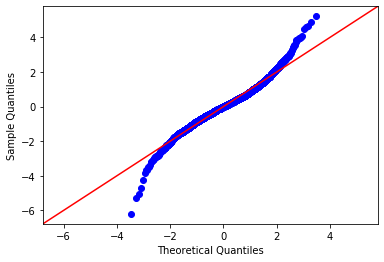

In [25]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)